In [13]:
import pandas as pd

# Load CSV
df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv")

# Parse date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')


In [14]:
print(df.info())
print(df['Date'].min(), "→", df['Date'].max())
print(df['Date'].diff().value_counts())  # Check frequency


<class 'pandas.core.frame.DataFrame'>
Index: 1918 entries, 1013 to 160
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1918 non-null   datetime64[ns]
 1   Local Route   1918 non-null   int64         
 2   Light Rail    1918 non-null   int64         
 3   Peak Service  1918 non-null   int64         
 4   Rapid Route   1918 non-null   int64         
 5   School        1918 non-null   int64         
 6   Other         1898 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 119.9 KB
None
2019-07-01 00:00:00 → 2024-09-29 00:00:00
Date
1 days    1917
Name: count, dtype: int64


In [15]:
df.fillna(0, inplace=True)

df.drop_duplicates(subset=['Date'], keep='first', inplace=True)

assert df['Date'].is_monotonic_increasing


In [16]:

df.set_index('Date', inplace=True)

service_types = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
datasets = {}

for service in service_types:
    series = df[[service]].copy()
    train = series[:-7]
    test = series[-7:]
    datasets[service] = {'train': train, 'test': test}


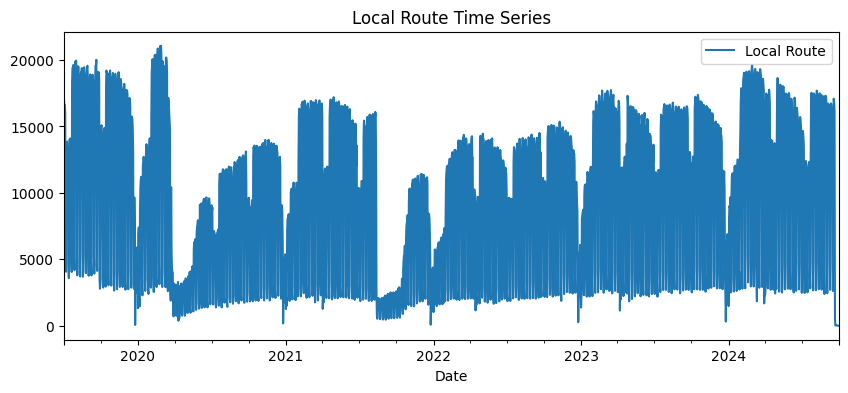

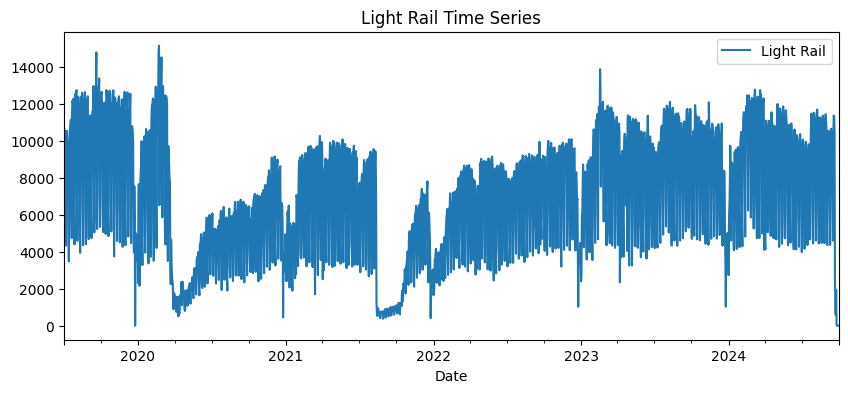

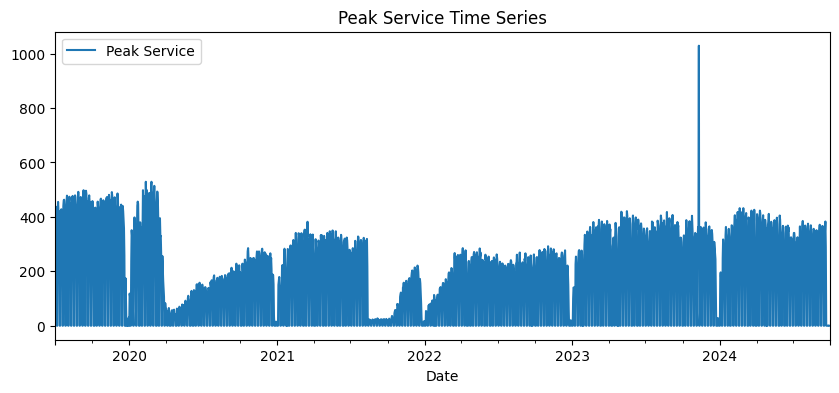

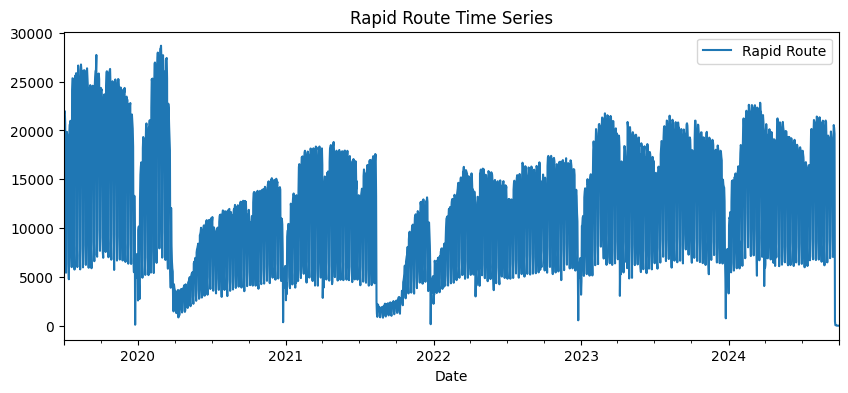

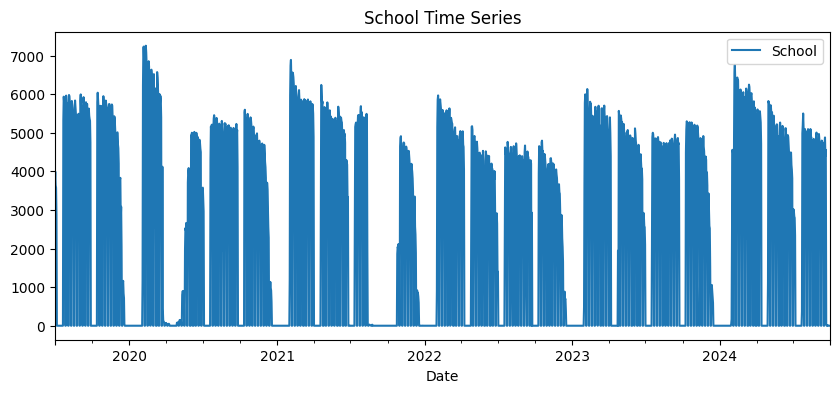

In [5]:
import matplotlib.pyplot as plt

for service in service_types:
    df[[service]].plot(title=f"{service} Time Series", figsize=(10, 4))
    plt.show()


In [17]:
from prophet import Prophet

prophet_models = {}
for service in service_types:
    train_df = datasets[service]['train'].reset_index().rename(columns={'Date': 'ds', service: 'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(train_df)
    prophet_models[service] = model


DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/57057_fu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/cqjwybmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95829', 'data', 'file=/tmp/tmp02u64z47/57057_fu.json', 'init=/tmp/tmp02u64z47/cqjwybmo.json', 'output', 'file=/tmp/tmp02u64z47/prophet_modeld0qwpkl1/prophet_model-20250527055204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:52:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/afsl7ubu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/3mjailn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

metrics = {}
for service in service_types:
    model = prophet_models[service]
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    y_pred = forecast.set_index('ds').loc[datasets[service]['test'].index]['yhat']
    y_true = datasets[service]['test'][service]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    metrics[service] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


In [19]:
# Retrain on full data and forecast next 7 days
final_forecasts = {}

for service in service_types:
    full_df = df[[service]].reset_index().rename(columns={'Date': 'ds', service: 'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(full_df)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    final_forecasts[service] = forecast[['ds', 'yhat']].tail(7)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/h53__co9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/t0_3cn0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43942', 'data', 'file=/tmp/tmp02u64z47/h53__co9.json', 'init=/tmp/tmp02u64z47/t0_3cn0l.json', 'output', 'file=/tmp/tmp02u64z47/prophet_model32euugk8/prophet_model-20250527055332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/a_fhvoqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/mig8n69s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/hxodwxr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/k11va900.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33644', 'data', 'file=/tmp/tmp02u64z47/hxodwxr7.json', 'init=/tmp/tmp02u64z47/k11va900.json', 'output', 'file=/tmp/tmp02u64z47/prophet_modelg6ownmc7/prophet_model-20250527055343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


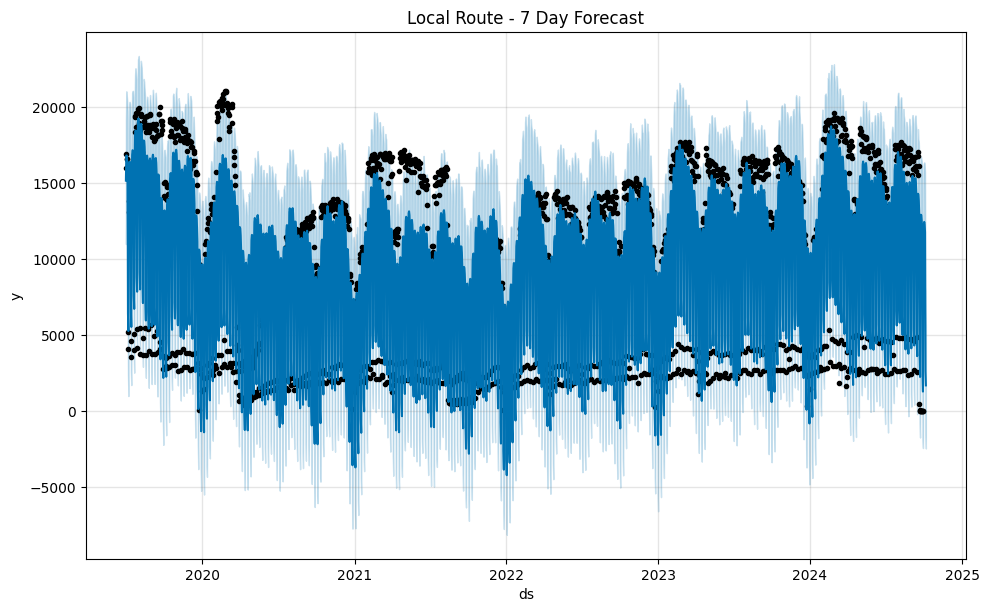

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/xj9u0v4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/rly9pk6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21414', 'data', 'file=/tmp/tmp02u64z47/xj9u0v4j.json', 'init=/tmp/tmp02u64z47/rly9pk6f.json', 'output', 'file=/tmp/tmp02u64z47/prophet_modeleg_pkm1d/prophet_model-20250527055345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


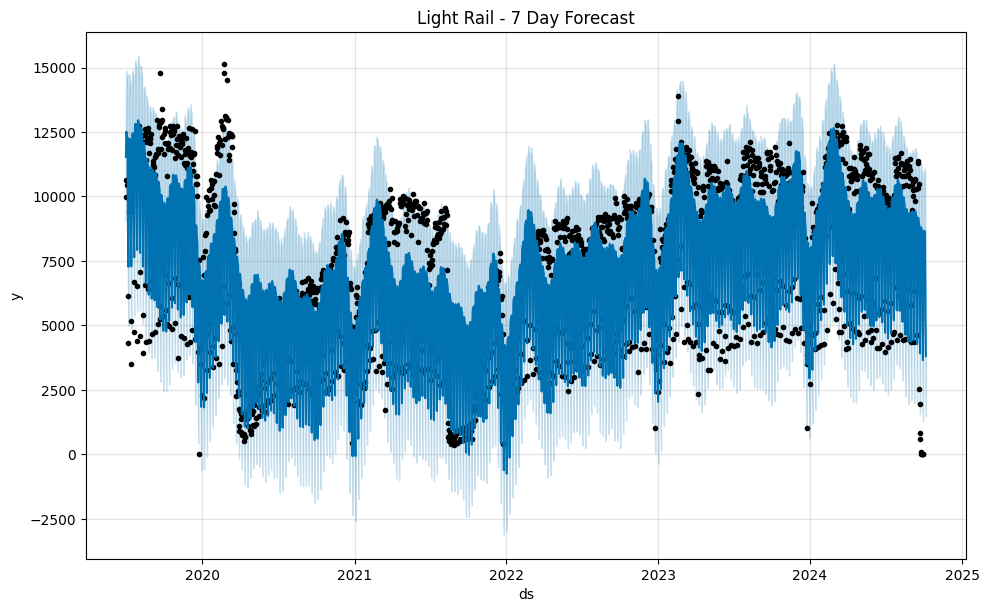

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/7m4i1w3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/tmv00sl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83147', 'data', 'file=/tmp/tmp02u64z47/7m4i1w3s.json', 'init=/tmp/tmp02u64z47/tmv00sl3.json', 'output', 'file=/tmp/tmp02u64z47/prophet_modelc0106zmz/prophet_model-20250527055346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


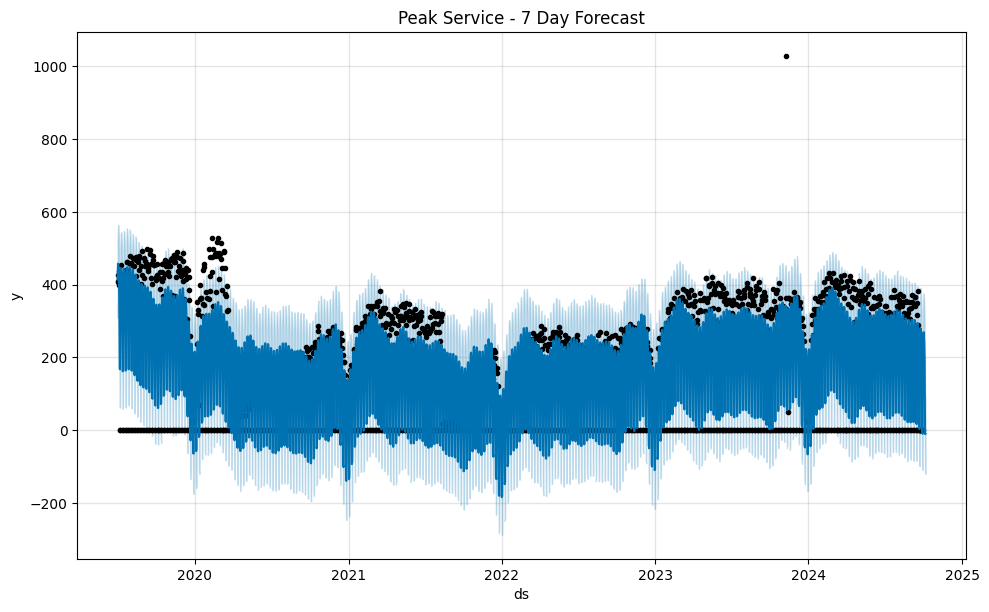

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/kd4jwa8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/7ewvwryz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88993', 'data', 'file=/tmp/tmp02u64z47/kd4jwa8p.json', 'init=/tmp/tmp02u64z47/7ewvwryz.json', 'output', 'file=/tmp/tmp02u64z47/prophet_modeleokla5tc/prophet_model-20250527055347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


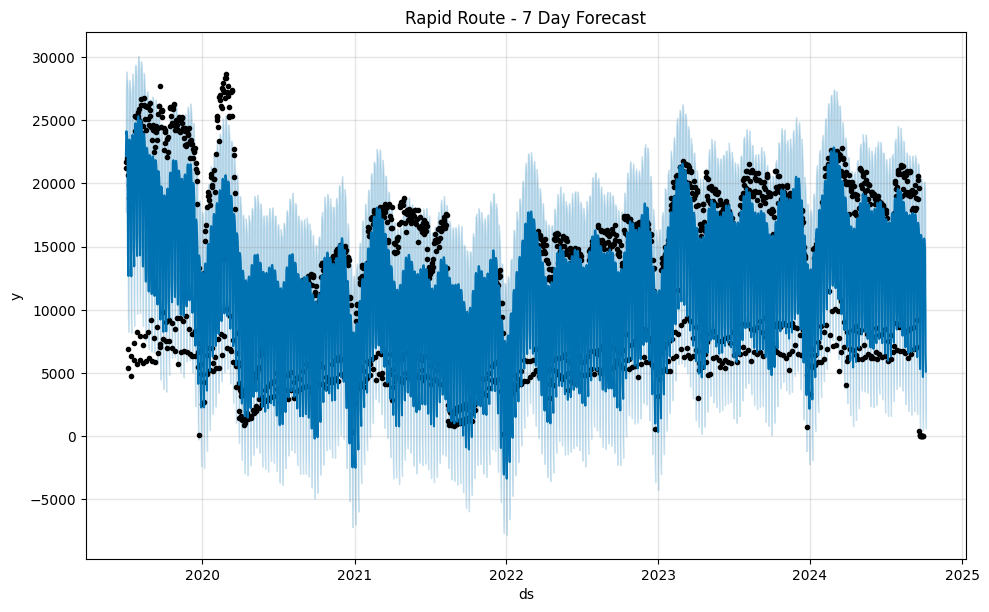

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/62rr5fco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp02u64z47/6kp4zub_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60750', 'data', 'file=/tmp/tmp02u64z47/62rr5fco.json', 'init=/tmp/tmp02u64z47/6kp4zub_.json', 'output', 'file=/tmp/tmp02u64z47/prophet_model_0kzb1u3/prophet_model-20250527055348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


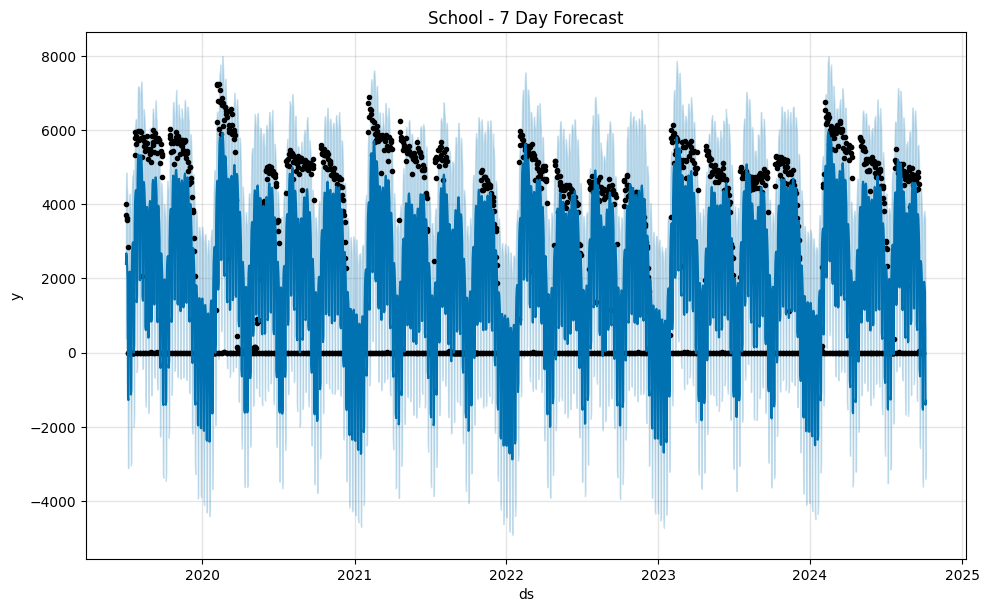

In [20]:
for service in service_types:
    model = Prophet()
    full_df = df[[service]].reset_index().rename(columns={'Date': 'ds', service: 'y'})
    model.fit(full_df)
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title(f"{service} - 7 Day Forecast")
    plt.show()
